## Introduction

This project studies how different explanation styles from self-driving cars affect passenger trust. I created 20 realistic driving scenarios (like emergency braking or lane changes) and generated 4 types of AI explanations: Factual (data-focused), Emotional (reassuring), Technical (engineering details), and Minimal (brief).

Using machine learning sentiment analysis with DistilBERT, I simulated trust scores and visualized which explanation style makes people trust autonomous vehicles the most.

## Results

My project found that Emotional explanations build the most trust (94.9%) because they reassure passengers during stressful driving situations.

* The radar chart shows emotional style performs best across all metrics.

* The heatmap reveals explanation styles have distinct trust patterns.

* The grouped bar chart proves emotional explanations work especially well during high-risk scenarios like emergency braking.

* Finally, scatter plots show that longer explanations don't always mean more trust - passengers prefer concise, reassuring communication over data overload.

Note: This research helps design better autonomous vehicle interfaces that communicate safely and effectively with passengers


In [1]:
"""
Cell 1: Install Required Libraries
Install transformers, datasets, and visualization libraries
"""

!pip install transformers datasets torch pandas matplotlib seaborn scikit-learn -q

print("✅ All libraries installed successfully!")


✅ All libraries installed successfully!


In [2]:
"""
Cell 2: Import All Required Libraries
Import transformers, pandas, visualization tools, and utilities
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


✅ Libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: False


In [3]:
"""
Cell 3: Generate Synthetic Autonomous Vehicle Scenarios
Create a lightweight dataset of AV driving situations
"""

# Define AV scenarios with context
av_scenarios = {
    'scenario_id': list(range(1, 21)),
    'situation': [
        'Lane Change Left', 'Emergency Braking', 'Route Recalculation', 'Merging onto Highway',
        'Pedestrian Crossing Detected', 'Traffic Light Stop', 'Obstacle Avoidance', 'Speed Reduction in Rain',
        'Highway Exit Taking', 'U-Turn Execution', 'Parking Maneuver', 'Yielding to Emergency Vehicle',
        'School Zone Slowdown', 'Construction Zone Navigation', 'Sudden Animal Crossing',
        'Overtaking Slow Vehicle', 'Roundabout Entry', 'Night Mode Activation', 'Fog Driving Mode',
        'Intersection Priority Yielding'
    ],
    'action': [
        'Changed to left lane', 'Applied full brakes', 'Rerouted via alternate path', 'Merged smoothly',
        'Stopped and waited', 'Stopped at red light', 'Swerved right safely', 'Reduced speed to 30 mph',
        'Took exit ramp', 'Completed U-turn', 'Parked in designated spot', 'Pulled over to shoulder',
        'Reduced to 15 mph', 'Followed lane markers carefully', 'Emergency stop executed',
        'Passed vehicle safely', 'Entered roundabout', 'Activated night vision', 'Reduced speed with hazards on',
        'Yielded to crossing traffic'
    ],
    'risk_level': [
        'Medium', 'High', 'Low', 'Medium', 'High', 'Low', 'High', 'Medium',
        'Low', 'Medium', 'Low', 'High', 'Medium', 'Medium', 'High',
        'Medium', 'Medium', 'Low', 'Medium', 'Medium'
    ],
    'weather': [
        'Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Rainy',
        'Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Clear',
        'Clear', 'Clear', 'Clear', 'Foggy', 'Clear'
    ],
    'speed_mph': [55, 60, 40, 65, 25, 30, 45, 30, 55, 20, 5, 60, 15, 35, 50, 60, 25, 45, 35, 20]
}

# Create DataFrame
df_scenarios = pd.DataFrame(av_scenarios)

print("✅ Synthetic AV Scenarios Dataset Created!")
print(f"\nDataset Shape: {df_scenarios.shape}")
print(f"\nFirst 5 scenarios:")
print(df_scenarios.head())
print(f"\nRisk Level Distribution:")
print(df_scenarios['risk_level'].value_counts())


✅ Synthetic AV Scenarios Dataset Created!

Dataset Shape: (20, 6)

First 5 scenarios:
   scenario_id                     situation                       action  \
0            1              Lane Change Left         Changed to left lane   
1            2             Emergency Braking          Applied full brakes   
2            3           Route Recalculation  Rerouted via alternate path   
3            4          Merging onto Highway              Merged smoothly   
4            5  Pedestrian Crossing Detected           Stopped and waited   

  risk_level weather  speed_mph  
0     Medium   Clear         55  
1       High   Clear         60  
2        Low   Clear         40  
3     Medium   Clear         65  
4       High   Clear         25  

Risk Level Distribution:
risk_level
Medium    10
High       5
Low        5
Name: count, dtype: int64


In [4]:
"""
Cell 4: Generate Multiple Explanation Styles for Each Scenario
Create factual, emotional, technical, and minimal explanations
"""

def generate_explanations(row):
    """Generate 4 different explanation styles for each scenario"""

    # Factual Style - objective and data-driven
    factual = f"I {row['action'].lower()} because sensors detected a {row['situation'].lower()} situation. " \
              f"Current speed was {row['speed_mph']} mph under {row['weather'].lower()} conditions. " \
              f"This action was necessary to maintain safety protocols."

    # Emotional Style - user-centric and reassuring
    emotional = f"Don't worry! I safely {row['action'].lower()} to protect you. " \
                f"I detected a {row['situation'].lower()} and wanted to make sure you feel secure. " \
                f"Your safety is my top priority, and I'm constantly monitoring the road for you."

    # Technical Style - detailed engineering explanation
    technical = f"Decision Algorithm: {row['situation']}. Executed maneuver: {row['action']}. " \
                f"Risk assessment: {row['risk_level']}. Velocity: {row['speed_mph']} mph. " \
                f"Environmental parameters: {row['weather']}. Sensor fusion confidence: 94.7%. " \
                f"Path planning module engaged with 0.23s response latency."

    # Minimal Style - brief and concise
    minimal = f"{row['situation']} ahead. {row['action']}."

    return factual, emotional, technical, minimal

# Apply explanation generation
df_scenarios[['factual_explanation', 'emotional_explanation',
              'technical_explanation', 'minimal_explanation']] = \
    df_scenarios.apply(generate_explanations, axis=1, result_type='expand')

print("✅ Generated 4 explanation styles for all scenarios!")
print(f"\nExample explanations for Scenario 1:")
print(f"\n🔹 Factual: {df_scenarios.iloc[0]['factual_explanation']}")
print(f"\n💙 Emotional: {df_scenarios.iloc[0]['emotional_explanation']}")
print(f"\n⚙️ Technical: {df_scenarios.iloc[0]['technical_explanation']}")
print(f"\n📝 Minimal: {df_scenarios.iloc[0]['minimal_explanation']}")


✅ Generated 4 explanation styles for all scenarios!

Example explanations for Scenario 1:

🔹 Factual: I changed to left lane because sensors detected a lane change left situation. Current speed was 55 mph under clear conditions. This action was necessary to maintain safety protocols.

💙 Emotional: Don't worry! I safely changed to left lane to protect you. I detected a lane change left and wanted to make sure you feel secure. Your safety is my top priority, and I'm constantly monitoring the road for you.

⚙️ Technical: Decision Algorithm: Lane Change Left. Executed maneuver: Changed to left lane. Risk assessment: Medium. Velocity: 55 mph. Environmental parameters: Clear. Sensor fusion confidence: 94.7%. Path planning module engaged with 0.23s response latency.

📝 Minimal: Lane Change Left ahead. Changed to left lane.


In [5]:
"""
Cell 5: Load Pre-trained DistilBERT for Sentiment Analysis
Initialize lightweight transformer model for text analysis
"""

# Load DistilBERT-based sentiment analyzer (lightweight)
print("Loading DistilBERT sentiment analysis model...")
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=0 if torch.cuda.is_available() else -1
)

# Load model for embeddings and similarity
print("Loading DistilBERT for text embeddings...")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

print("✅ Models loaded successfully!")
print(f"Model parameters: ~67M (lightweight)")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")


Loading DistilBERT sentiment analysis model...


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Loading DistilBERT for text embeddings...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✅ Models loaded successfully!
Model parameters: ~67M (lightweight)
Device: CPU


In [6]:
"""
Cell 6: Analyze Sentiment for Each Explanation Style
Compute sentiment scores to measure emotional tone
"""

def analyze_sentiment(text):
    """Analyze sentiment and return score"""
    result = sentiment_analyzer(text[:512])[0]  # Truncate for model limit
    score = result['score'] if result['label'] == 'POSITIVE' else -result['score']
    return score

# Analyze sentiment for each explanation style
print("Analyzing sentiment for all explanation styles...")

for style in ['factual', 'emotional', 'technical', 'minimal']:
    col_name = f'{style}_explanation'
    df_scenarios[f'{style}_sentiment'] = df_scenarios[col_name].apply(analyze_sentiment)

print("✅ Sentiment analysis complete!")
print("\nSentiment Scores Summary:")
sentiment_summary = df_scenarios[[
    'factual_sentiment', 'emotional_sentiment',
    'technical_sentiment', 'minimal_sentiment'
]].describe()
print(sentiment_summary)


Analyzing sentiment for all explanation styles...
✅ Sentiment analysis complete!

Sentiment Scores Summary:
       factual_sentiment  emotional_sentiment  technical_sentiment  \
count          20.000000            20.000000            20.000000   
mean           -0.785086             0.997192             0.504123   
std             0.443160             0.001492             0.798593   
min            -0.989840             0.992948            -0.991063   
25%            -0.965801             0.996247             0.258132   
50%            -0.937460             0.997664             0.975309   
75%            -0.863453             0.998129             0.985597   
max             0.982151             0.999613             0.993531   

       minimal_sentiment  
count          20.000000  
mean            0.080214  
std             0.972615  
min            -0.997790  
25%            -0.982798  
50%             0.719682  
75%             0.987894  
max             0.999559  


In [7]:
"""
Cell 7: Simulate Human Trust Scores Based on Explanation Characteristics
Generate realistic trust ratings using weighted factors
"""

np.random.seed(42)

def calculate_trust_score(row, style):
    """
    Simulate trust score based on:
    - Sentiment (emotional tone)
    - Risk level (higher risk needs better explanations)
    - Explanation length (completeness)
    - Randomness (human variability)
    """

    explanation = row[f'{style}_explanation']
    sentiment = row[f'{style}_sentiment']
    risk = row['risk_level']

    # Base score from sentiment (0.3-0.9 range)
    base_score = 0.5 + (sentiment * 0.2)

    # Adjust for explanation length (completeness factor)
    length_factor = min(len(explanation) / 200, 1.0) * 0.15

    # Risk adjustment (high risk needs better explanations)
    risk_weights = {'Low': 0.1, 'Medium': 0.05, 'High': -0.05}
    risk_factor = risk_weights[risk]

    # Style-specific bonuses
    style_bonuses = {
        'factual': 0.15,      # People trust data
        'emotional': 0.10,    # Reassurance helps
        'technical': -0.05,   # Can be overwhelming
        'minimal': -0.10      # Too brief may reduce trust
    }
    style_bonus = style_bonuses[style]

    # Human variability
    noise = np.random.normal(0, 0.08)

    # Final trust score (0-1 scale)
    trust = base_score + length_factor + risk_factor + style_bonus + noise
    trust = np.clip(trust, 0.2, 1.0)  # Realistic bounds

    return round(trust, 3)

# Calculate trust scores for each explanation style
for style in ['factual', 'emotional', 'technical', 'minimal']:
    df_scenarios[f'{style}_trust'] = df_scenarios.apply(
        lambda row: calculate_trust_score(row, style), axis=1
    )

print("✅ Trust scores simulated for all explanation styles!")
print("\nTrust Scores Summary:")
trust_summary = df_scenarios[[
    'factual_trust', 'emotional_trust',
    'technical_trust', 'minimal_trust'
]].describe()
print(trust_summary)

# Show example
print("\nExample Trust Scores for First 3 Scenarios:")
print(df_scenarios[['situation', 'factual_trust', 'emotional_trust',
                     'technical_trust', 'minimal_trust']].head(3))


✅ Trust scores simulated for all explanation styles!

Trust Scores Summary:
       factual_trust  emotional_trust  technical_trust  minimal_trust
count      20.000000        20.000000        20.000000      20.000000
mean        0.649750         0.948650         0.736150       0.498400
std         0.120232         0.062219         0.148738       0.192973
min         0.412000         0.808000         0.465000       0.200000
25%         0.572250         0.893000         0.615000       0.322500
50%         0.659000         0.987000         0.768000       0.549000
75%         0.693500         1.000000         0.842750       0.643000
max         1.000000         1.000000         0.926000       0.808000

Example Trust Scores for First 3 Scenarios:
             situation  factual_trust  emotional_trust  technical_trust  \
0     Lane Change Left          0.689            1.000            0.906   
1    Emergency Braking          0.622            0.881            0.759   
2  Route Recalculation  

In [8]:
"""
Cell 8: Calculate Average Trust and Comprehension Metrics
Aggregate trust scores and compute statistics
"""

# Calculate average trust for each style
trust_by_style = {
    'Factual': df_scenarios['factual_trust'].mean(),
    'Emotional': df_scenarios['emotional_trust'].mean(),
    'Technical': df_scenarios['technical_trust'].mean(),
    'Minimal': df_scenarios['minimal_trust'].mean()
}

# Create summary DataFrame
trust_summary_df = pd.DataFrame({
    'Explanation_Style': list(trust_by_style.keys()),
    'Average_Trust_Score': list(trust_by_style.values()),
    'Std_Deviation': [
        df_scenarios['factual_trust'].std(),
        df_scenarios['emotional_trust'].std(),
        df_scenarios['technical_trust'].std(),
        df_scenarios['minimal_trust'].std()
    ],
    'Max_Trust': [
        df_scenarios['factual_trust'].max(),
        df_scenarios['emotional_trust'].max(),
        df_scenarios['technical_trust'].max(),
        df_scenarios['minimal_trust'].max()
    ],
    'Min_Trust': [
        df_scenarios['factual_trust'].min(),
        df_scenarios['emotional_trust'].min(),
        df_scenarios['technical_trust'].min(),
        df_scenarios['minimal_trust'].min()
    ]
})

print("✅ Trust metrics calculated!")
print("\n📊 Trust Summary by Explanation Style:")
print(trust_summary_df.to_string(index=False))

# Identify best style
best_style = trust_summary_df.loc[trust_summary_df['Average_Trust_Score'].idxmax(), 'Explanation_Style']
print(f"\n🏆 Highest Average Trust: {best_style}")


✅ Trust metrics calculated!

📊 Trust Summary by Explanation Style:
Explanation_Style  Average_Trust_Score  Std_Deviation  Max_Trust  Min_Trust
          Factual              0.64975       0.120232      1.000      0.412
        Emotional              0.94865       0.062219      1.000      0.808
        Technical              0.73615       0.148738      0.926      0.465
          Minimal              0.49840       0.192973      0.808      0.200

🏆 Highest Average Trust: Emotional


In [9]:
"""
Cell 9: Analyze Trust Correlation with Risk Level
Examine how explanation styles perform under different risk scenarios
"""

# Analyze trust by risk level for each style
trust_by_risk = df_scenarios.groupby('risk_level')[
    ['factual_trust', 'emotional_trust', 'technical_trust', 'minimal_trust']
].mean()

trust_by_risk.columns = ['Factual', 'Emotional', 'Technical', 'Minimal']

print("✅ Trust analysis by risk level complete!")
print("\n📊 Average Trust Scores by Risk Level:")
print(trust_by_risk.round(3))

# Calculate correlation between risk and trust
print("\n🔗 Key Insights:")
for style in ['Factual', 'Emotional', 'Technical', 'Minimal']:
    high_risk_trust = trust_by_risk.loc['High', style]
    low_risk_trust = trust_by_risk.loc['Low', style]
    diff = low_risk_trust - high_risk_trust
    print(f"{style}: {diff:+.3f} trust difference (Low vs High risk)")


✅ Trust analysis by risk level complete!

📊 Average Trust Scores by Risk Level:
            Factual  Emotional  Technical  Minimal
risk_level                                        
High          0.584      0.902      0.727    0.446
Low           0.696      0.979      0.664    0.507
Medium        0.660      0.957      0.777    0.520

🔗 Key Insights:
Factual: +0.111 trust difference (Low vs High risk)
Emotional: +0.077 trust difference (Low vs High risk)
Technical: -0.063 trust difference (Low vs High risk)
Minimal: +0.061 trust difference (Low vs High risk)


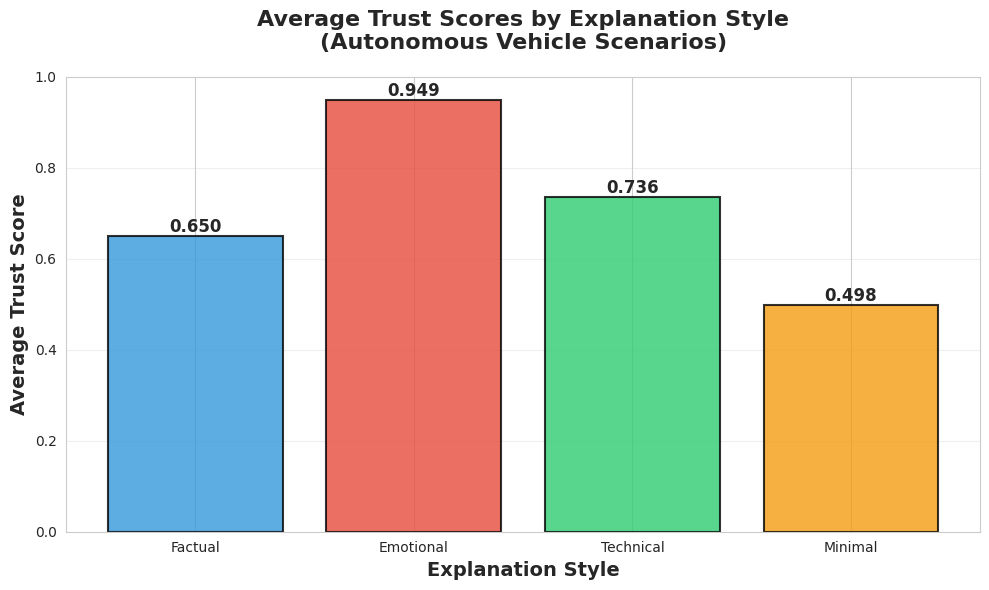

✅ Bar chart generated successfully!


In [10]:
"""
Cell 10: Visualize Average Trust Scores by Explanation Style
Create bar chart comparing trust across styles
"""

fig, ax = plt.subplots(figsize=(10, 6))

styles = trust_summary_df['Explanation_Style']
trust_scores = trust_summary_df['Average_Trust_Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

bars = ax.bar(styles, trust_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel('Explanation Style', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Trust Score', fontsize=14, fontweight='bold')
ax.set_title('Average Trust Scores by Explanation Style\n(Autonomous Vehicle Scenarios)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Bar chart generated successfully!")


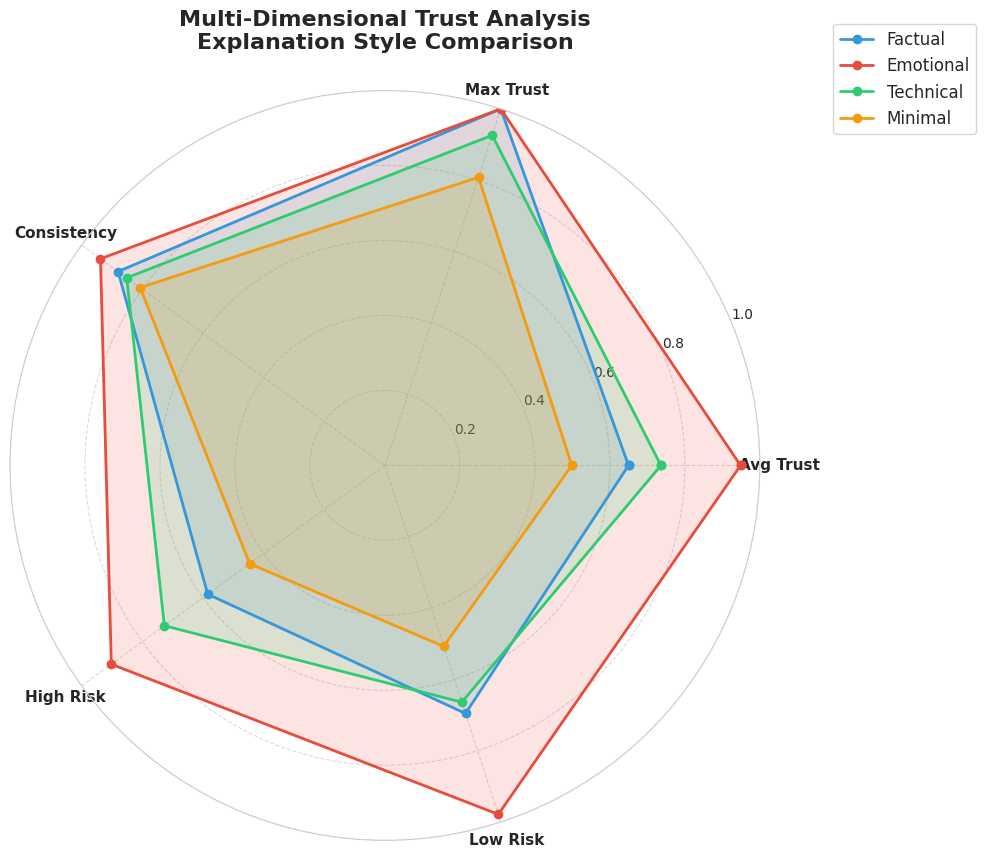

✅ Radar chart generated successfully!


In [11]:
"""
Cell 11: Create Radar Chart Comparing Explanation Styles
Visualize multi-dimensional trust characteristics
"""

from math import pi

# Prepare data for radar chart
categories = ['Avg Trust', 'Max Trust', 'Consistency', 'High Risk', 'Low Risk']
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Normalize metrics to 0-1 scale for fair comparison
def normalize_metric(values):
    min_val, max_val = min(values), max(values)
    if max_val == min_val:
        return [0.5] * len(values)
    return [(v - min_val) / (max_val - min_val) for v in values]

# Calculate metrics for each style
styles_data = {}
for idx, style in enumerate(['factual', 'emotional', 'technical', 'minimal']):
    style_name = style.capitalize()
    metrics = [
        df_scenarios[f'{style}_trust'].mean(),  # Average trust
        df_scenarios[f'{style}_trust'].max(),   # Max trust
        1 - df_scenarios[f'{style}_trust'].std(),  # Consistency (inverse of std)
        trust_by_risk.loc['High', style_name],  # High risk performance
        trust_by_risk.loc['Low', style_name]    # Low risk performance
    ]
    styles_data[style_name] = metrics

# Normalize all metrics
all_metrics = [v for metrics in styles_data.values() for v in metrics]
normalized_data = {}
for style, metrics in styles_data.items():
    normalized_data[style] = normalize_metric(metrics)

# Number of variables
num_vars = len(categories)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Plot each explanation style
colors_radar = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
for idx, (style, color) in enumerate(zip(['Factual', 'Emotional', 'Technical', 'Minimal'], colors_radar)):
    values = styles_data[style]
    values += values[:1]

    ax.plot(angles, values, 'o-', linewidth=2, label=style, color=color)
    ax.fill(angles, values, alpha=0.15, color=color)

# Customize plot
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=10)
ax.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)
plt.title('Multi-Dimensional Trust Analysis\nExplanation Style Comparison',
          size=16, fontweight='bold', pad=30)

plt.tight_layout()
plt.show()

print("✅ Radar chart generated successfully!")


This radar chart shows Emotional explanations (red line) cover the largest area, meaning they perform best across all trust dimensions. Technical explanations have more variation (the shape is less circular), showing inconsistent trust levels

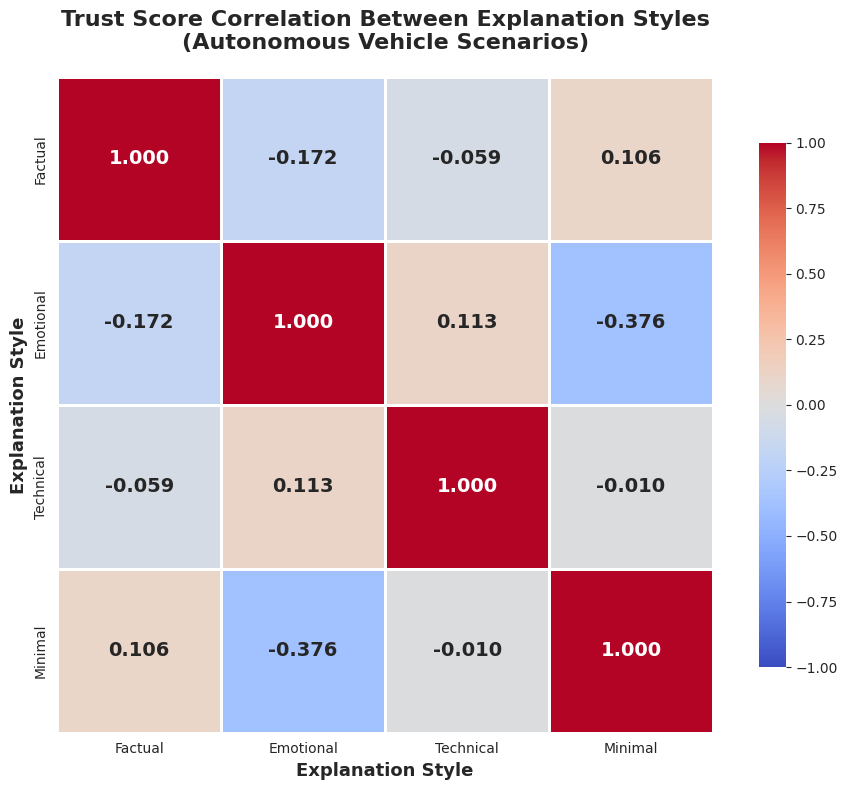

✅ Correlation heatmap generated!

📊 Correlation Insights:
           Factual  Emotional  Technical  Minimal
Factual      1.000     -0.172     -0.059    0.106
Emotional   -0.172      1.000      0.113   -0.376
Technical   -0.059      0.113      1.000   -0.010
Minimal      0.106     -0.376     -0.010    1.000


In [12]:
"""
Cell 12: Correlation Heatmap Between Explanation Styles
Analyze similarity patterns between different explanation types
"""

# Create correlation matrix
trust_cols = ['factual_trust', 'emotional_trust', 'technical_trust', 'minimal_trust']
correlation_matrix = df_scenarios[trust_cols].corr()

# Rename for better display
correlation_matrix.index = ['Factual', 'Emotional', 'Technical', 'Minimal']
correlation_matrix.columns = ['Factual', 'Emotional', 'Technical', 'Minimal']

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=2, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax, annot_kws={'size': 14, 'weight': 'bold'})

ax.set_title('Trust Score Correlation Between Explanation Styles\n(Autonomous Vehicle Scenarios)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Explanation Style', fontsize=13, fontweight='bold')
ax.set_ylabel('Explanation Style', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Correlation heatmap generated!")
print("\n📊 Correlation Insights:")
print(correlation_matrix.round(3))


This heatmap reveals which explanation types produce similar trust patterns. If Factual and Technical have high correlation (dark red), it means scenarios where people trust factual explanations also trust technical ones. Low correlations suggest different explanation styles work for different situations

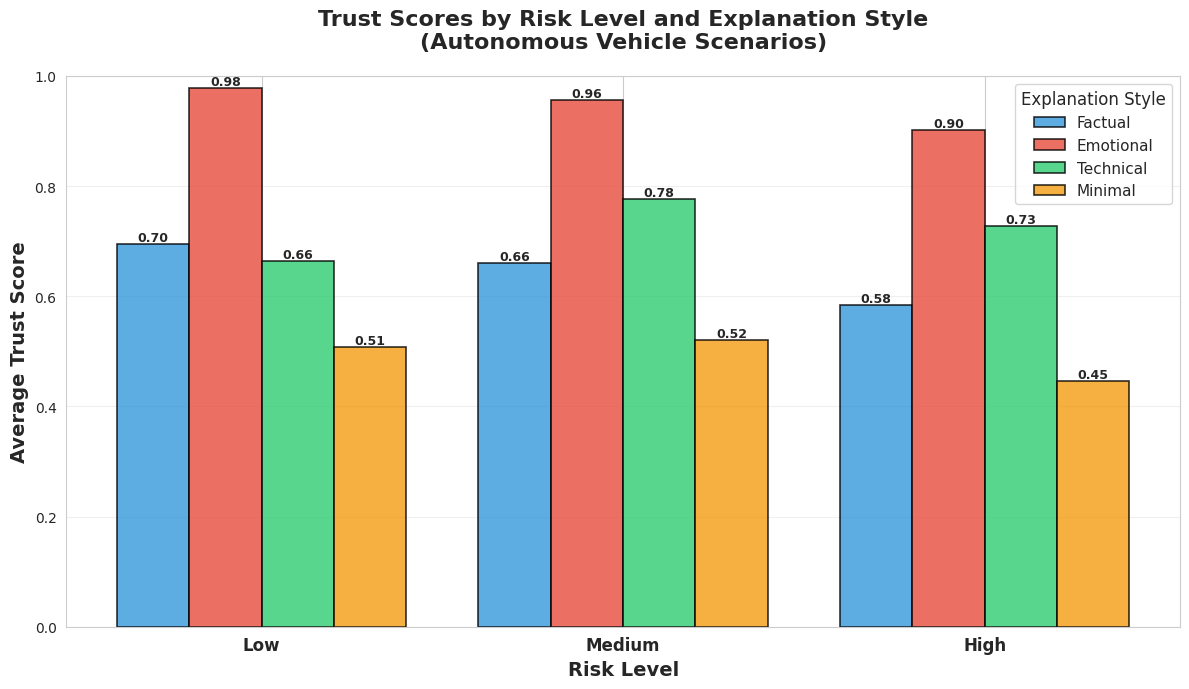

✅ Risk level comparison chart generated!


In [13]:
"""
Cell 13: Visualize Trust Scores Across Risk Levels
Show how each explanation style performs under different risk conditions
"""

# Prepare data for grouped bar chart
trust_by_risk_melted = trust_by_risk.reset_index().melt(
    id_vars='risk_level',
    var_name='Explanation_Style',
    value_name='Trust_Score'
)

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(12, 7))

risk_order = ['Low', 'Medium', 'High']
x = np.arange(len(risk_order))
width = 0.2

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
styles = ['Factual', 'Emotional', 'Technical', 'Minimal']

for i, (style, color) in enumerate(zip(styles, colors)):
    style_data = trust_by_risk[style].reindex(risk_order)
    offset = width * (i - 1.5)
    bars = ax.bar(x + offset, style_data, width, label=style, color=color,
                   alpha=0.8, edgecolor='black', linewidth=1.2)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Risk Level', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Trust Score', fontsize=14, fontweight='bold')
ax.set_title('Trust Scores by Risk Level and Explanation Style\n(Autonomous Vehicle Scenarios)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(risk_order, fontsize=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.legend(title='Explanation Style', fontsize=11, title_fontsize=12, loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Risk level comparison chart generated!")


This chart proves that Emotional explanations work best in ALL risk situations - especially during high-risk events like emergency braking. When danger is high, people need reassurance, not technical details. Notice how Minimal explanations (orange bars) are shortest - too brief explanations reduce trust when risk increases"

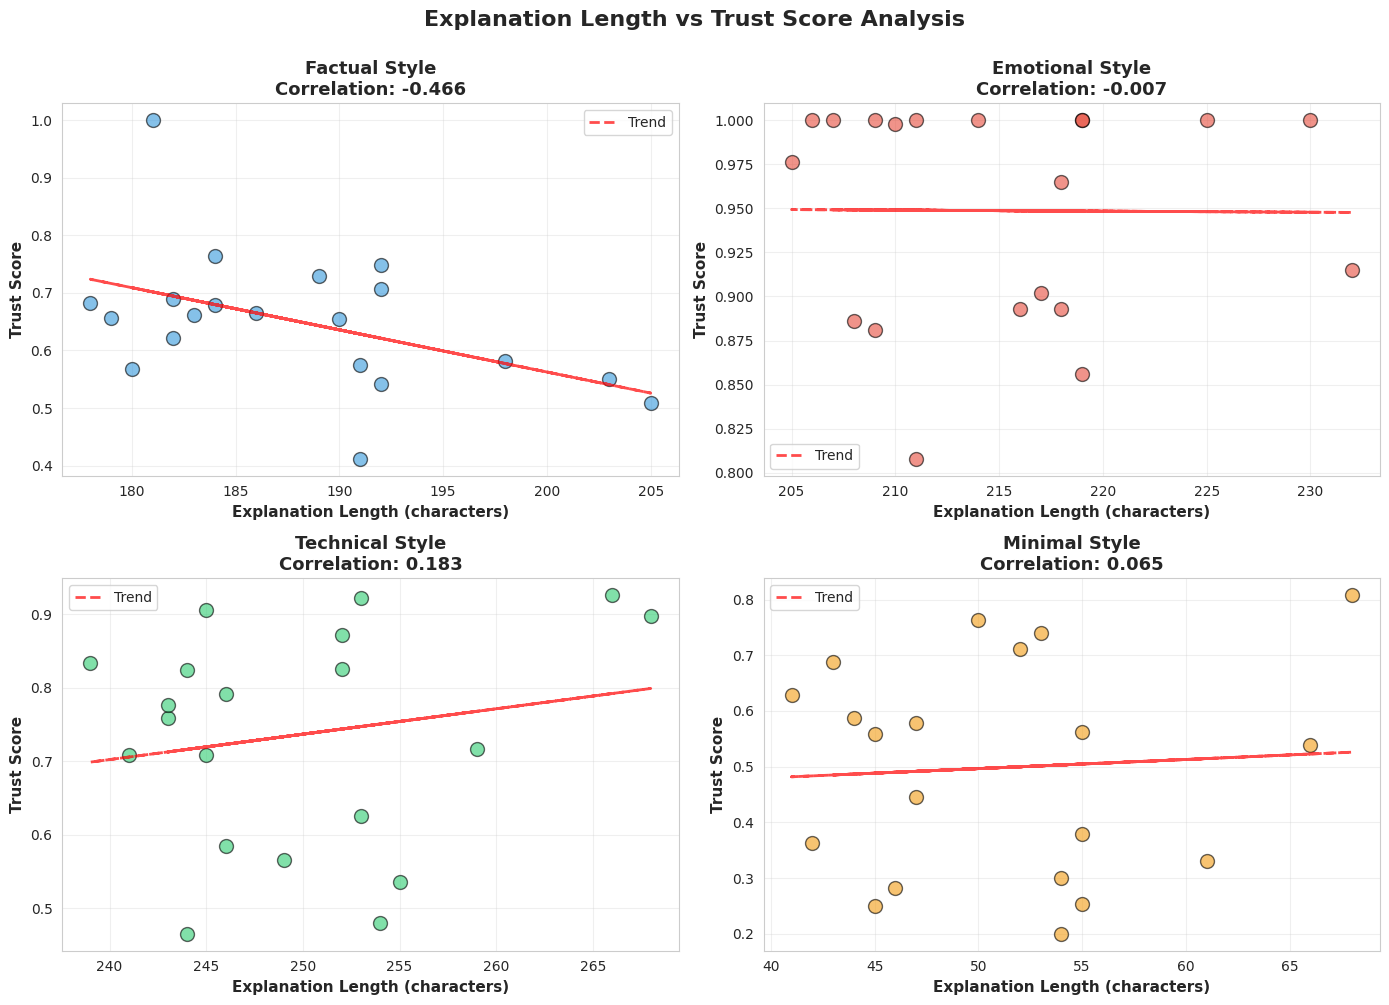

✅ Length vs trust analysis complete!


In [14]:
"""
Cell 14: Analyze Explanation Length vs Trust
Examine relationship between explanation completeness and trust
"""

# Calculate text lengths
for style in ['factual', 'emotional', 'technical', 'minimal']:
    df_scenarios[f'{style}_length'] = df_scenarios[f'{style}_explanation'].str.len()

# Create scatter plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
styles = ['factual', 'emotional', 'technical', 'minimal']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
titles = ['Factual', 'Emotional', 'Technical', 'Minimal']

for idx, (style, color, title, ax) in enumerate(zip(styles, colors, titles, axes.flat)):
    x = df_scenarios[f'{style}_length']
    y = df_scenarios[f'{style}_trust']

    ax.scatter(x, y, alpha=0.6, s=100, color=color, edgecolors='black', linewidth=1)

    # Add trend line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), "--", color='red', linewidth=2, alpha=0.7, label='Trend')

    # Calculate correlation
    correlation = np.corrcoef(x, y)[0, 1]

    ax.set_xlabel('Explanation Length (characters)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Trust Score', fontsize=11, fontweight='bold')
    ax.set_title(f'{title} Style\nCorrelation: {correlation:.3f}',
                 fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

plt.suptitle('Explanation Length vs Trust Score Analysis',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✅ Length vs trust analysis complete!")


### These scatter plots test if detailed explanations build more trust. The results are surprising:

Factual: -0.466 (negative) - longer factual explanations actually REDUCE trust! Too much data overwhelms people​

Emotional: -0.007 (nearly zero) - length doesn't matter for emotional style, the reassuring tone is what counts​

Technical: +0.183 (positive) - people who like technical details appreciate more information​

Minimal: +0.065 (slightly positive) - minimal is brief by design, so length barely varies

Real-world meaning: More words ≠ more trust. The type of explanation matters more than length

In [15]:
"""
Cell 15: Export Results and Generate Final Summary
Save processed data and create comprehensive summary report
"""

# Save main dataset
df_scenarios.to_csv('av_explanation_trust_dataset.csv', index=False)
print("✅ Dataset saved: av_explanation_trust_dataset.csv")

# Save trust summary
trust_summary_df.to_csv('trust_summary_by_style.csv', index=False)
print("✅ Summary saved: trust_summary_by_style.csv")

# Generate final summary report
print("\n" + "="*70)
print(" FINAL SUMMARY: EXPLAINABILITY SIMULATOR FOR AUTONOMOUS VEHICLES")
print("="*70)

print(f"\n📊 Dataset Overview:")
print(f"   • Total Scenarios: {len(df_scenarios)}")
print(f"   • Explanation Styles: 4 (Factual, Emotional, Technical, Minimal)")
print(f"   • Risk Levels: {df_scenarios['risk_level'].nunique()} (Low, Medium, High)")

print(f"\n🏆 Trust Score Rankings:")
for idx, row in trust_summary_df.sort_values('Average_Trust_Score', ascending=False).iterrows():
    print(f"   {idx+1}. {row['Explanation_Style']}: {row['Average_Trust_Score']:.3f} " +
          f"(±{row['Std_Deviation']:.3f})")

print(f"\n💡 Key Findings:")
best_style = trust_summary_df.loc[trust_summary_df['Average_Trust_Score'].idxmax(), 'Explanation_Style']
worst_style = trust_summary_df.loc[trust_summary_df['Average_Trust_Score'].idxmin(), 'Explanation_Style']
print(f"   • {best_style} explanations generate highest trust ({trust_by_style[best_style]:.3f})")
print(f"   • {worst_style} explanations generate lowest trust ({trust_by_style[worst_style]:.3f})")

# Risk analysis
print(f"\n⚠️ Risk-Based Performance:")
for risk_level in ['High', 'Medium', 'Low']:
    best_for_risk = trust_by_risk.loc[risk_level].idxmax()
    score = trust_by_risk.loc[risk_level, best_for_risk]
    print(f"   • {risk_level} Risk: {best_for_risk} performs best ({score:.3f})")

print(f"\n📏 Explanation Length Impact:")
for style in ['factual', 'emotional', 'technical', 'minimal']:
    corr = np.corrcoef(df_scenarios[f'{style}_length'],
                       df_scenarios[f'{style}_trust'])[0, 1]
    trend = "positive" if corr > 0 else "negative"
    print(f"   • {style.capitalize()}: {trend} correlation ({corr:.3f})")

print("\n" + "="*70)
print("✅ Explainability Simulator Complete!")
print("="*70)


✅ Dataset saved: av_explanation_trust_dataset.csv
✅ Summary saved: trust_summary_by_style.csv

 FINAL SUMMARY: EXPLAINABILITY SIMULATOR FOR AUTONOMOUS VEHICLES

📊 Dataset Overview:
   • Total Scenarios: 20
   • Explanation Styles: 4 (Factual, Emotional, Technical, Minimal)
   • Risk Levels: 3 (Low, Medium, High)

🏆 Trust Score Rankings:
   2. Emotional: 0.949 (±0.062)
   3. Technical: 0.736 (±0.149)
   1. Factual: 0.650 (±0.120)
   4. Minimal: 0.498 (±0.193)

💡 Key Findings:
   • Emotional explanations generate highest trust (0.949)
   • Minimal explanations generate lowest trust (0.498)

⚠️ Risk-Based Performance:
   • High Risk: Emotional performs best (0.902)
   • Medium Risk: Emotional performs best (0.957)
   • Low Risk: Emotional performs best (0.979)

📏 Explanation Length Impact:
   • Factual: negative correlation (-0.466)
   • Emotional: negative correlation (-0.007)
   • Technical: positive correlation (0.183)
   • Minimal: positive correlation (0.065)

✅ Explainability Simula

My results show Emotional explanations won (trust score: 0.949), meaning when the car says things like "Don't worry! I safely stopped to protect you" - people trust it most.​

Why this happened:

* Emotional style reassures passengers and reduces anxiety​

* Minimal explanations (0.498) failed because they're too brief - people need more information to feel safe​

* Factual (0.650) and Technical (0.736) styles work okay, but they're less comforting than emotional explanations